# Imports and helper functions

In [1]:
import numpy as np
import torch
import sys
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

from scipy.stats import linregress
from tqdm import tqdm

plt.style.use('seaborn-white', )
plt.rcParams['axes.labelsize'] =  25
plt.rcParams['ytick.labelsize'] = 15.0
plt.rcParams['xtick.labelsize'] = 15.0
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sys.path.insert(1, '../single_patch_orientation')
from orientation_stim import broadband_noise, gabor, grating, circular_mask

In [2]:
from torch import nn
import torch.nn.functional as F

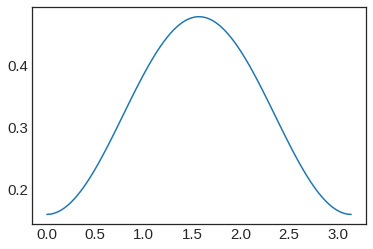

In [6]:
import scipy.stats as st

class my_pdf(st.rv_continuous):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def _pdf(self,x):
        return (-np.cos(2*x)+2)/(2*np.pi)

my_cv = my_pdf(a=0, b=np.pi, name='my_pdf')
# plt.hist(my_cv.rvs(size=1000))
plt.plot(np.linspace(0,np.pi,100), my_cv._pdf(np.linspace(0,np.pi,100)))

In [7]:
def circular_mse(x1,x2):
    """ Returns MSE, but if distance is greater than pi/2 then choose the shorter circular path.
    pi/2 instead of pi since orientation repeats at pi"""
    x2p = torch.where((x1-x2)>np.pi/2, x2+np.pi, x2)
    x1p = torch.where((x2-x1)>np.pi/2, x1+np.pi, x1)
    r1= F.mse_loss(x1p,x2p)
    return r1



In [8]:
def get_rot_mat(theta, device="cuda:0"):
    if isinstance(theta,torch.Tensor):
        theta = theta.to(device).clone().detach()
    else:
        theta = torch.tensor(theta, device=device)
    return torch.tensor([[torch.cos(theta), -torch.sin(theta), 0],
                         [torch.sin(theta), torch.cos(theta), 0]], device=device)


def rot_img(x, theta, dtype,device="cuda:0"):
    rot_mat = get_rot_mat(theta, device=device)[None, ...].type(dtype).repeat(x.shape[0],1,1)
    grid = F.affine_grid(rot_mat, x.size(),align_corners=False).type(dtype)
    x = F.grid_sample(x, grid, align_corners=False, )
    return x

In [9]:
blur_mask = torch.tensor(circular_mask(64, pixelsPerDegree=30,if_filtered=True), device="cuda:0")
                         
def sinusoid(freq,phase=0, orientation=0, device="cuda:0"):
    arr= torch.ones(1,1,64,64, device=device)
    arr*=torch.linspace(0,3.14159,64, device=device)
    arr2d = torch.cos(freq*arr+phase)
    arr2d = rot_img(arr2d, orientation + np.pi/2, arr2d.dtype, device=device)[0,0]
    x, y = torch.meshgrid(torch.arange(64, device=device), torch.arange(64, device=device))
    x = (x - 64 / 2.0)
    y = (y - 64 / 2.0)
    arr2d *= blur_mask
    return arr2d[None]
    

(-0.5, 63.5, 63.5, -0.5)

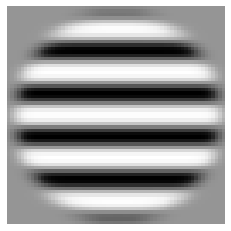

In [10]:
plt.imshow(sinusoid(10,0,0)[0].cpu(), cmap='Greys')
plt.axis('off')

In [11]:
def get_sensitivity(func, i, eps=1e-3):
    diff= (func(i+eps) - func(i-eps))/(2*eps)
    return diff.pow(2).sum()

### With output noise instead of input noise

In [12]:
### MSE vs theta
def plot_map_sin(net,n_bins=30,n=60,ax=None):
    if ax==None:
        plt.figure()
        ax=plt.gca()
    orientations = torch.linspace(0,np.pi,n).view(n,1).expand(n,1).reshape(-1)
    orientation_stim = [sinusoid(10,0,o.numpy(), device='cuda:0') for o in orientations]
    orientation_stim = torch.stack(orientation_stim)[:,None].cuda()
    orientations = torch.Tensor(orientations)[:,None].cuda()

    _,_,o_est = net(orientation_stim)

#     ax.plot(torch.linspace(0,np.pi,n_bins),err.detach().cpu().numpy())
    ax.plot(torch.linspace(0,np.pi,n),o_est.argmax(1).detach().cpu().numpy() * (np.pi/n_bins))
#     plt.ylim(0,2)

# plot_map_sin(net)

In [13]:
    
class FFNet(nn.Module):
    def __init__(self, scale=1, n_out=60, linear=False):
        super().__init__()
        self.linear1 = nn.Sequential(nn.Linear(64**2, 32**2)) if linear else nn.Sequential(nn.Linear(64**2, 32**2),nn.ReLU())
        self.linear2 = nn.Sequential(nn.Linear(32**2, 16**2)) if linear else nn.Sequential(nn.Linear(32**2, 16**2),nn.ReLU(),)
        self.linear3 = nn.Sequential(nn.Linear(16**2, n_out))
        self.n_out = n_out
        for mod in (self.linear1, self.linear2, self.linear3):
            mod[0].weight.data *= scale
            mod[0].bias.data *= scale
        
    def forward(self,x):
        low = self.linear1(x.view(-1,64**2))
        mid = self.linear2(low)
        top = self.linear3(mid) 
        theta = F.log_softmax(top,1)
        return low,mid,theta.view(-1,self.n_out)
    
    

In [14]:
def plot_sensitivity(net, n=60,n_phases=11,ax=None, layer=0):
#     if ax==None:
#         plt.figure()
#         ax = plt.gca()
    orients = [torch.autograd.Variable(o, requires_grad=True) for o in torch.linspace(0,np.pi,n)]
    net.cuda()
    sensitivity=[]
    for o in orients:
        all_sens=[]

        for phase in np.linspace(0,np.pi,n_phases):
            def func(x):
                outputs = net(sinusoid(10,phase,x, device="cuda:0")[None].view(-1,64**2))
                return outputs[layer].exp() if layer ==-1 else outputs[layer]
            all_sens.append(get_sensitivity(func, o))
        sensitivity.append(torch.stack(all_sens).mean().detach().cpu())
    sensitivity = torch.stack(sensitivity)
#     sensitivity /= torch.sum(sensitivity)/50
    
#     ax.plot(np.linspace(0,np.pi,n),my_cv._pdf(np.linspace(0,np.pi,n)))
#     ax.plot(np.linspace(0,np.pi,n),sensitivity)
    return sensitivity

net = FFNet(.1).cuda()
plot_sensitivity(net)

tensor([24.9443, 27.6859, 29.4505, 30.0958, 27.7567, 27.1945, 26.6837, 26.8943,
        28.7489, 27.9037, 26.3678, 27.3474, 27.3158, 29.4604, 29.7061, 29.0295,
        28.7243, 28.0406, 26.1409, 26.1940, 26.3969, 26.3996, 26.5355, 27.4659,
        27.9386, 28.3467, 27.9909, 26.3333, 25.6950, 26.0909, 27.2232, 28.1668,
        28.2387, 28.3228, 28.9182, 29.1832, 29.3255, 28.9101, 27.6648, 27.6423,
        26.8841, 27.4991, 29.4706, 27.9432, 27.4807, 27.0331, 27.8351, 25.6531,
        25.9725, 27.1708, 26.5476, 26.8668, 26.9207, 27.0483, 26.7927, 27.7384,
        27.1704, 28.2655, 27.1808, 24.9581])

In [15]:
def one_hot_orientation(o, n_bins=60):
    # first bin
    o = (o /np.pi * n_bins).to(int)
    return F.one_hot(o.squeeze(), n_bins)
def discretize(o,n_bins=60):
    assert o.max() <= np.pi and o.min()>=0
    o = (o /np.pi * n_bins).to(int)
    return o.squeeze()

# one_hot_orientation(torch.zeros(1));discretize(o);

In [16]:
def pos_angle(o):
    o = torch.where(o<0,     np.pi-o, o)
    o = torch.where(o>np.pi, o-np.pi, o)
    return o

#### specify $H[\hat{\theta}|\theta]$ as a function of $p(\theta)$.




In [17]:
def noise_labels(y, ps):
    """Applies Bernoulli noise on the output labels with probability
    ps. p=1 corresponds to no noise. In the event of a noise-induced dropout, places mass on a null category.
    Assumes y is not 1hot but rather numerical category indicator, like F.nll_loss"""
    n_categories = len(ps)
    not_dropped = torch.bernoulli(ps[y]).to(y.device)
    y = torch.where(not_dropped.bool(), y, n_categories)
    return y


def fake_noise_labels(y,ps):
    """ACts like noise_labels, but goes as deterministically as possible, dropping as close to 1-ps proportion
    as doable"""
    for l in range(len(ps)):
        idx = torch.where(y==l)[0]
        n_to_drop = int(len(idx) - len(idx)*ps[l])
        y[idx[:n_to_drop]] = len(ps)
    return y

    
assert (noise_labels(torch.arange(5), torch.ones(5)) -  torch.arange(5)).sum() ==0
assert (noise_labels(torch.arange(5), torch.zeros(5)) - torch.ones(5)*5).sum() ==0
    
assert (fake_noise_labels(torch.arange(5), torch.ones(5)) -  torch.arange(5)).sum() ==0
assert (fake_noise_labels(torch.arange(5), torch.zeros(5)) - torch.ones(5)*5).sum() ==0

In [18]:
n_bins=60


# A flat spectrum 
W = torch.linalg.qr(torch.randn(n_bins,n_bins), )[0]
Y = F.one_hot(torch.arange(n_bins).repeat(500), n_bins).float() # (n_binsx50) x nbins
X = Y@W 
# X.size()
torch.svd(X.T@Y, compute_uv=False)[1]

# a nonflat spectrum
Y_noisy =  F.one_hot(fake_noise_labels(torch.arange(n_bins).repeat(500), torch.linspace(0,1,n_bins)), n_bins+1).float()
torch.svd(X.T@Y_noisy[:,:-1], compute_uv=False)[1].numpy();



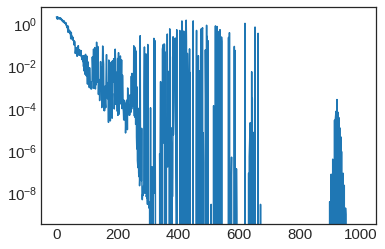

In [19]:
n_out = 60
net = nn.Sequential(nn.Linear(n_out,650),nn.Linear(650,n_out), nn.LogSoftmax(dim=1)).cuda()

#control init
scale=1
for mod in net[:-1]:
    mod.weight.data *= scale
    mod.bias.data *= scale

optim = torch.optim.SGD(net.parameters(),0.1)
net.train()
losses = []

for i in range(1000):
        
        
    y = torch.randint(0,n_out, size=(128,))
    Y = F.one_hot(y,n_out).float()
    X = Y@W
    noised_y = noise_labels(y,#torch.ones(n_out)
                            torch.linspace(0,1,n_out)
                           )
    
    
    Y_hat = net(X.cuda()).squeeze()
    Y_hat = torch.cat((Y_hat, -1e-10*torch.zeros(128,1, device=Y_hat.device)),dim=1) # don't train the null
    loss = F.nll_loss(Y_hat.cpu(), noised_y.squeeze())
    
    loss.backward()
#     nn.utils.clip_grad_norm_(net.parameters(), 100)
    optim.step()   
    losses.append(loss.item())
plt.semilogy(losses)

In [20]:
def plot_sensitivity_linear(net, n_categories, n=60,n_phases=11,ax=None, layer=0):
    if ax==None:
        plt.figure()
        ax = plt.gca()
    orients = torch.linspace(0,n_categories,n)
    sensitivity=[]

    for o in orients:
        def func(x):
            return net(o)
            outputs = net(sinusoid(10,phase,x, device="cuda:0")[None].view(-1,64**2))
            return outputs[layer]


    net.cuda()
    sensitivity=[]
    for o in orients:
        all_sens=[]

        for phase in np.linspace(0,np.pi,n_phases):
            def func(x):
                outputs = net(sinusoid(10,phase,x, device="cuda:0")[None].view(-1,64**2))
                return outputs[layer]
            all_sens.append(get_sensitivity(func, o))
        sensitivity.append(torch.stack(all_sens).mean().detach().cpu())
    sensitivity = torch.stack(sensitivity)
#     sensitivity /= torch.sum(sensitivity)/50
    
#     ax.plot(np.linspace(0,np.pi,n),my_cv._pdf(np.linspace(0,np.pi,n)))
    ax.plot(np.linspace(0,np.pi,n),sensitivity)

net = FFNet(.1).cuda()
plot_sensitivity(net)

tensor([26.6711, 27.7213, 26.6151, 27.9773, 28.8738, 29.1383, 26.7634, 26.5804,
        27.9574, 27.1208, 27.2575, 27.8605, 28.4602, 28.3999, 28.4660, 27.7880,
        27.6832, 27.9705, 26.6363, 25.8852, 27.0328, 28.3492, 28.6920, 27.8042,
        28.0759, 27.9814, 27.9465, 27.7543, 26.2204, 26.4237, 27.0647, 26.0443,
        24.2966, 25.4422, 26.3812, 25.9926, 26.1877, 25.6263, 26.8755, 26.3877,
        26.6666, 26.7235, 26.1339, 27.2014, 28.4631, 27.8067, 26.5462, 26.9463,
        27.2984, 28.9414, 27.4769, 27.1872, 27.0564, 27.1260, 27.4874, 27.7931,
        28.1315, 28.0542, 27.5235, 25.4018])

In [21]:
def binary_entropy(p):
    return (-(1-p)*torch.log(1-p) - p*torch.log(p))/np.log(2)

_p = torch.linspace(.5,1-1e-6,10000)
_H = binary_entropy(_p)
def inverse_binary_entropy_lookup(H):
    return _p[torch.argmin((_H.view(-1,1)-H.view(1,-1)).abs(), 0)]

H = torch.linspace(0,1,5)
inverse_binary_entropy_lookup(H);

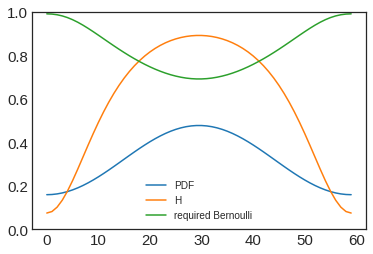

In [22]:
class my_pdf(st.rv_continuous):
    def _pdf(self,x):
        return (-np.cos(2*x)+2)/(2*np.pi)
my_cv = my_pdf(a=0, b=np.pi)

plt.plot(my_cv._pdf(torch.linspace(0,np.pi,n_out)), label="PDF")

b, a = 1.3, .15
h = b - b*a/my_cv._pdf(torch.linspace(0,np.pi,n_out))
plt.plot(h, label = "H")
plt.plot(inverse_binary_entropy_lookup(h), label="required Bernoulli")
plt.ylim(0,1)
plt.legend()

# this sets the H[x|x] = p(x)
# what we want is that, on average over a dataset, any x is as informative as another.
# the total information for seeing an x is the sum of seeing it once, times frequency.
# The information conveyed about \hat{x} by observing an x is (1-H[x|x]), (the change in H from the uniform)
# 
# this means that p(x)(1-H[x|x]) = p(x)(1-H[x|x]) for any two orientations
# in general this is satistfied if (1-H[x_1|x_1])/(1-H[x_2|x_2]) = p(x_2)/p(x_1)
# or H = b(1 - a / p(x)) for some constants a, b

/home/abenjamin/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  del sys.path[0]


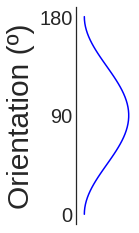

/home/abenjamin/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


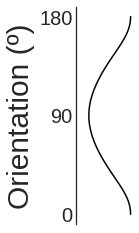

In [24]:
plt.figure(figsize=(1,4))
plt.plot(my_cv._pdf(torch.linspace(0,np.pi,n_out)),#inverse_binary_entropy_lookup(h),
         torch.linspace(0,180,n_out),'b')
ax=plt.gca()
ax.get_xaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
t=ax.set_yticks([0,90,180])
ax.set_yticklabels([0,90,180],fontsize=20)
ax.set_xlim(.1,.5)
ax.set_ylabel("Orientation (º)",fontsize=30)
plt.tight_layout()
plt.savefig("figures/p_x_schema.svg")
plt.show()

plt.figure(figsize=(1,4))
plt.plot(inverse_binary_entropy_lookup(h),
         torch.linspace(0,180,n_out),'k')
ax=plt.gca()
ax.get_xaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks([0,90,180])
ax.set_yticklabels([0,90,180],fontsize=20)

ax.set_xlim(.6,1)
ax.set_ylabel("Orientation (º)",fontsize=30)
plt.tight_layout()
# plt.savefig("figures/noise_schema.svg")

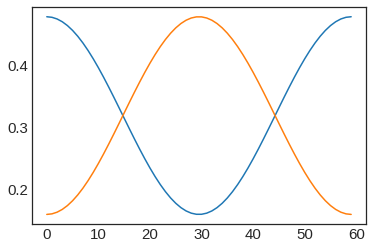

In [25]:
my_cv = my_pdf(a=0, b=np.pi)
class my_pdf_inv(st.rv_continuous):
    def _pdf(self,x):
        return (np.cos(2*x)+2)/(2*np.pi)
my_cv_inv = my_pdf_inv(a=0, b=np.pi)
plt.plot(my_cv_inv._pdf(torch.linspace(0,np.pi,n_out)), label="PDF")
plt.plot(my_cv._pdf(torch.linspace(0,np.pi,n_out)), label="PDF")


In [27]:
n_out = 60
net = FFNet(.1,n_out=n_out).cuda()
optim = torch.optim.SGD(net.parameters(),.5)
net.train()
losses = []
batch = 2048

pdf = lambda x: (torch.cos(2*x)+2)/(2*np.pi)
orientations= torch.linspace(0,np.pi,n_out, device="cuda:0")

all_sensitivity = []
# plt.figure()
# ax = plt.gca()
cat_of_interest = [0,15,30]
accuracy_by_category = -torch.ones(300,n_out)
for i in tqdm(range(300)):
    
    if 0:
#         f,axs = plt.subplots(1,2,figsize=(10,5))
        
#         plot_map_sin(net,ax=axs[0], n_bins=n_out)
#         all_sensitivity.append(plot_sensitivity(net,layer=0))
#         plt.show()
        
        plot_external_noise_curve(net, n=30,n_phases=100,ax=ax, layer=0, o=np.pi/2)

        
    
    # make x
    orientations = torch.tensor(my_cv.rvs(size=batch), device="cuda:0")
#     orientations = torch.rand(batch, device="cuda:0")*np.pi
    
    ####
    optim.zero_grad()
    orientation_stim = [sinusoid(10,torch.rand(1, device="cuda:0")*np.pi,o, device='cuda:0') for o in orientations]
    orientation_stim = torch.stack(orientation_stim)[:,None].cuda()

    
    y = discretize(orientations, n_out)
    noised_y = noise_labels(y,torch.ones(n_out)
                            #inverse_binary_entropy_lookup(h)
                           )
        
    low,mid,o_est = net(orientation_stim)
    Y_hat = torch.cat((o_est, torch.zeros(batch,1, device=o_est.device)),dim=1) # don't train the null
    
    loss = F.nll_loss(Y_hat, noised_y.squeeze())
    loss.backward()
    optim.step()   
    ####
    overall_acc = (y==o_est.argmax(1)).sum().float()/batch
    for cat in cat_of_interest:
        orientations = (torch.rand(2000, device="cuda:0")+cat)*np.pi/60

        ####
        optim.zero_grad()
        orientation_stim = [sinusoid(10,torch.rand(1, device="cuda:0")*np.pi,o, device='cuda:0') for o in orientations]
        orientation_stim = torch.stack(orientation_stim)[:,None].cuda()
        y = discretize(orientations, n_out)
        low,mid,o_est = net(orientation_stim)       
        
        idx = torch.where(y==cat)[0]
        if len(idx)>0:
            accuracy_by_category[i,cat] = (y[idx]==o_est[idx].argmax(1)).sum().float()/len(idx)
    
    
    losses.append(overall_acc.item())

# plt.show()

100%|██████████| 300/300 [39:39<00:00,  7.93s/it] 


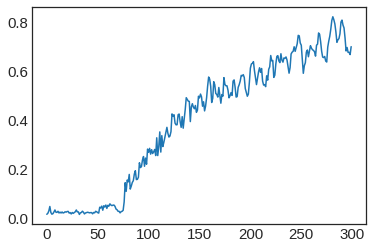

In [95]:
plt.plot(losses)

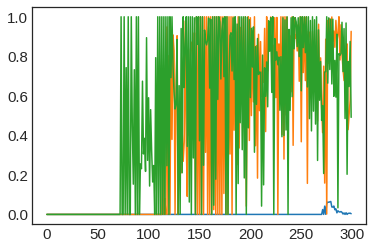

In [97]:
a = accuracy_by_category[:,0]
plt.plot(a)
a = accuracy_by_category[:,15]
plt.plot(a)
a = accuracy_by_category[:,30]
plt.plot(a)

In [37]:
im = torch.stack(all_sensitivity).T
# plt.imshow(im/1e5, extent=(0, 500, 0, 180*5/3), cmap = 'Greys', )
# plt.xlabel("Training time")
# plt.ylabel("Orientation")
# cb = plt.colorbar(shrink=.6, aspect=10, )
# cb.set_label(label='Sensitivity', fontsize=20, labelpad=10)
# plt.tight_layout()
# plt.savefig("figures/controlled_reading_BA.svg")
# plt.show()

plt.imshow(im/1e5, extent=(0, 500, 0, 180*5/3), cmap = 'Blues', vmax=1)
plt.xlabel("Training time")
plt.ylabel("Orientation")
cb = plt.colorbar(shrink=.6, aspect=10, )
cb.set_label(label='Sensitivity', fontsize=20, labelpad=10)
plt.tight_layout()
# plt.savefig("figures/controlled_reading_AB.svg")

RuntimeError: stack expects a non-empty TensorList

In [ ]:
plt.plot(all_sensitivity[-1])
# plt.savefig("figures/controlled_reading_AB_final_trace.svg")

In [ ]:
### External noise experiment
# At each snapshot we have the zero-noise sensitivity


In [ ]:
# BA_sensitivity = torch.stack(all_sensitivity)
AB_sensitivity = torch.stack(all_sensitivity)
torch.save(AB_sensitivity,"AB_sensitivity.p")

In [ ]:
# effect of an exposure burst 
def train_with_boost(start_boost,end_boost):
    n_out = 60
    net = FFNet(.05,n_out=n_out).cuda()
    optim = torch.optim.SGD(net.parameters(),1)
    net.train()
    losses = []
    batch = 1024

    pdf = lambda x: (torch.cos(2*x)+2)/(2*np.pi)
    orientations= torch.linspace(0,np.pi,n_out, device="cuda:0")

    all_sensitivity = []
    for i in tqdm(range(300)):

        if i%10==0:

            all_sensitivity.append(plot_sensitivity(net,layer=0))

        if i < end_boost and i>=start_boost:
            orientations = (torch.rand(batch, device="cuda:0")/6 + 5/60)*np.pi
        else:
            orientations = torch.tensor(my_cv.rvs(size=batch), device="cuda:0")

        ####
        optim.zero_grad()
        orientation_stim = [sinusoid(10,torch.rand(1, device="cuda:0")*np.pi,o, device='cuda:0') for o in orientations]
        orientation_stim = torch.stack(orientation_stim)[:,None].cuda()


        y = discretize(orientations, n_out)

        low,mid,o_est = net(orientation_stim)
        Y_hat = torch.cat((o_est, torch.zeros(batch,1, device=o_est.device)),dim=1) # don't train the null

        loss = F.nll_loss(Y_hat, y.squeeze())
        loss.backward()
        optim.step()      
    return all_sensitivity

In [ ]:
all_ims_output = []
for boost_start in range(0,300,30):
    boost_end = boost_start + 1
    all_sensitivity = train_with_boost(boost_start, boost_end)
    im = torch.stack(all_sensitivity).T
    all_ims_output.append(im)
    
    plt.imshow(im/1e5, extent=(0, 300, 0, 180), cmap = 'Blues')
    plt.xlabel("Training time")
    plt.ylabel("Orientation")
    cb = plt.colorbar(shrink=.6, aspect=10, )
    cb.set_label(label='Sensitivity', fontsize=20, labelpad=10)
    plt.tight_layout()
    plt.show()
# plt.savefig("figures/controlled_reading_AB.svg")

In [ ]:
for j in range(0,60):
    cs = sns.color_palette('cubehelix', len(all_ims))
    f, axs = plt.subplots(1,2, figsize=(8,4))
    for i,im in enumerate(all_ims_output):
        axs[0].plot(im[j], c=cs[i])
#         axs[0].vlines(k,0,max(im[j]), colors=cs[i], linewidth = 1, linestyle='dashed')
#         axs[1].scatter([k],[(im[j,k+1]-im[j,k])], color=cs[i])

#     axs[1].set_ylim(1e-4,1e4)
    axs[0].set_title(j)
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    
    
#     axs[1].set_xlabel("Burst timing")
    
    
    
    plt.show()
# all_ims[0].size()

## Predictions

Rate of change of sensitivity
- Depends on current sensitivity as a the difference to the asymptote times the absolute sensitivity to some exponent (can’t say what exponent, though, depends on depth)
- Depends on std dev of feature in question – linearly, all else held equal. Could test by observing rate of change of sensitivity before/after changing feature statistics

How perceptual sensitivity should change due to supervised tasks
- Separable frequency and importance effects – see Fig 5
- Gradient starvation - learning stops when task is learned

Sensitivity depends on length of exposure to a stimulus ensemble. 
- In the efficient coding framework, coding capacity increases with age because of more experience, until it reaches the noise ceiling. This is in contrast with previous proposals that internal noise decreases with age.

Controlled rearing
- Learn on data with some statistics. Then change the statistics and learn for an equal period. Should observe hysteresis: final sensitivity depends on which you did first.

The problem currently is that **no ceiling of sensitivity is found when the objective is log softmax.** The activations can tend arbitrarily large. This complicates the difference to the asymptote. We could just assume it's uniform?



In [ ]:
# first_inv = torch.stack(all_sensitivity)

In [ ]:
for i in range(60):
#     plt.plot(torch.stack(all_sensitivity)[:,-1])
    plt.plot(torch.stack(all_sensitivity)[:,i])
#     plt.xlim(150,350)
#     plt.vlines(250, 0,20000)
    plt.title(i)
    plt.show()

In [ ]:
### An RDD approach. Fit lines on either side of transition

def get_slope_ratio(sensitivity_series, margin):
    m = len(sensitivity_series)//2
    left_margin = min(margin, 50)
    r = linregress(range(m-left_margin,m), sensitivity_series[m-left_margin:m])
    r2 = linregress(range(m+5,m+margin), sensitivity_series[m+5:m+margin])
    std_est = r2.slope/r.slope * np.sqrt((r2.stderr/r2.slope)**2 + (r.stderr/r.slope)**2)
    return r2.slope/r.slope, std_est

for j in range(60):
    ls = np.array([get_slope_ratio(torch.stack(all_sensitivity)[:,j], i,) for i in range(7,100)])
    plt.plot(ls[:,0])
    plt.fill_between(range(7,100), ls[:,0] + ls[:,1], ls[:,0] - ls[:,1], alpha = .2)
    plt.xlabel("Margin")
    plt.ylabel(r"$\lambda_1/\lambda_2$")
    plt.title(j)
    plt.ylim(0,3)
    plt.show()

In [ ]:
ls = np.array([get_slope_ratio(torch.stack(all_sensitivity)[:,i], 200,) for i in range(60)])
plt.plot(ls[:,0])
plt.fill_between(range(60), ls[:,0] + ls[:,1], ls[:,0] - ls[:,1], alpha = .2)
plt.xlabel("Bin")
plt.ylabel(r"$\lambda_1/\lambda_2$")
plt.ylim(-1,3)
plt.grid()

p = my_cv_inv._pdf(torch.linspace(0,np.pi,60))
std_dev_inv = torch.sqrt(p*(1-p))
p = my_cv._pdf(torch.linspace(0,np.pi,60))
std_dev = torch.sqrt(p*(1-p))

plt.plot(std_dev/std_dev_inv)



In [ ]:
import seaborn as sns

In [ ]:
cs = sns.color_palette("husl", 60)

In [ ]:
for i in range(0,60,2
              ):
    plt.plot(sens_small_init[i,:290].reshape(-1), 
            F.conv1d(sens_small_init[i].view(1,1,-1), torch.ones(1,1,10)).squeeze().diff().reshape(-1), 
            alpha=.5, color=cs[i], #s=5,
            )
# plt.xlim(0,1000)
# plt.ylim(-1000,1000)
plt.xscale('log')
# plt.yscale('log')

In [ ]:
# std dev vs. learning rate @ a given sensitivity
p = my_cv._pdf(torch.linspace(0,np.pi,60))
std_dev = torch.sqrt(p*(1-p))

thresh = 500

at_thresh_idx = torch.argmin((sens_small_init[:1000]-thresh).abs(), dim=1)
smoothed_sens = F.conv1d(sens_small_init.view(60,1,-1), torch.ones(1,1,10), padding='same').squeeze()
lr_at_idx = [s[i] for s,i in zip(smoothed_sens.diff(), at_thresh_idx)]
# sens_small_init.diff()[idx]

# idx
# sens_small_init.size()
plt.scatter(std_dev, lr_at_idx)
plt.scatter(std_dev, at_thresh_idx)
